In [18]:
import sys
sys.path.append(r'c:\Users\m1srh\Documents\GitHub\BioFormatsRead')
#from skimage.external import tifffile
import itertools as it
import numpy as np
from skimage.filters import threshold_otsu, rank
from skimage.util import invert
from matplotlib import pyplot as plt, cm
import bftools as bf
import skimage
from skimage.morphology import white_tophat, disk, square
from skimage.filters import try_all_threshold, gaussian
import cv2
from cv2_rolling_ball import subtract_background_rolling_ball
from lxml import etree as etl
from skimage.external import tifffile

In [2]:
filename = r'c:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\Apeer\ZenCore_Workflows\ParticleAnalysis\Filtertest1_POLsm.czi'
urlnamespace = 'http://www.openmicroscopy.org/Schemas/OME/2016-06'
bfpackage = r'c:\Users\m1srh\Documents\Software\Bioformats\5.9.2\bioformats_package.jar'
bf.set_bfpath(bfpackage)

'c:\\Users\\m1srh\\Documents\\Software\\Bioformats\\5.9.2\\bioformats_package.jar'

In [5]:
# Get Omexml
omexml = bf.get_OMEXML(filename)

# get image meta-information
MetaInfo = bf.get_relevant_metainfo_wrapper(filename,
                                            namespace=urlnamespace,
                                            bfpath=bfpackage,
                                            showinfo=False,
                                            xyorder='YX')

try:
    img6d, readstate = bf.get_image6d_pylevel(filename, MetaInfo, pylevel=0)
    arrayshape = np.shape(img6d)
except:
    arrayshape = []
    print('Could not read image data into NumPy array.')

# show relevant image Meta-Information
bf.showtypicalmetadata(MetaInfo, namespace=urlnamespace, bfpath=bfpackage)
print('Array Shape          : ', arrayshape)

Multi-Resolution API not enabled yet.
Retrieving Image Dimensions ...
T:  1 Z:  1 C:  1 X:  4662 Y:  2061
Using czifile.py to get CZI Shape info.
Using BioFormats to get MetaInformation.
Problem reading Detector Model.
Reading MultiRes File.


OME NameSpace used   :  http://www.openmicroscopy.org/Schemas/OME/2016-06
BF Version used      :  c:\Users\m1srh\Documents\Software\Bioformats\5.9.2\bioformats_package.jar
-------------------------------------------------------------
Image Directory      :  c:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\Apeer\ZenCore_Workflows\ParticleAnalysis
Image Filename       :  Filtertest1_POLsm.czi
MutiResolution       :  True
Series Dimensions    :  [(4662, 2061), (1554, 687), (518, 229)]
Images Dim Sizes [0] :  [3, 1, 1, 1, 2061, 4662]
Dimension Order BF   :  XYCZT
Dimension Order CZI  :  TCZYX0
Shape CZI            :  (1, 1, 1, 2061, 4662, 1)
Total Series Number  :  3
Image Dimensions     :  3 1 1 1 2061 4662
Scaling XYZ [micron] :  0.546 0.546 0.546


In [9]:
x1=1200
x2=1400
y1=1200
y2=1400

array6d = invert(img6d)
array6d = array6d[:,:,:,:, x1:x2, y1:y2]
array6d.shape

(1, 1, 1, 1, 200, 200)

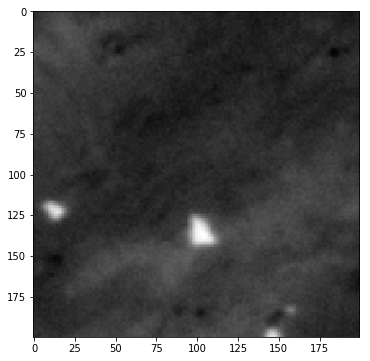

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(array6d[0,0,0,0,:,:], interpolation='nearest', cmap=cm.gray)
plt.show()

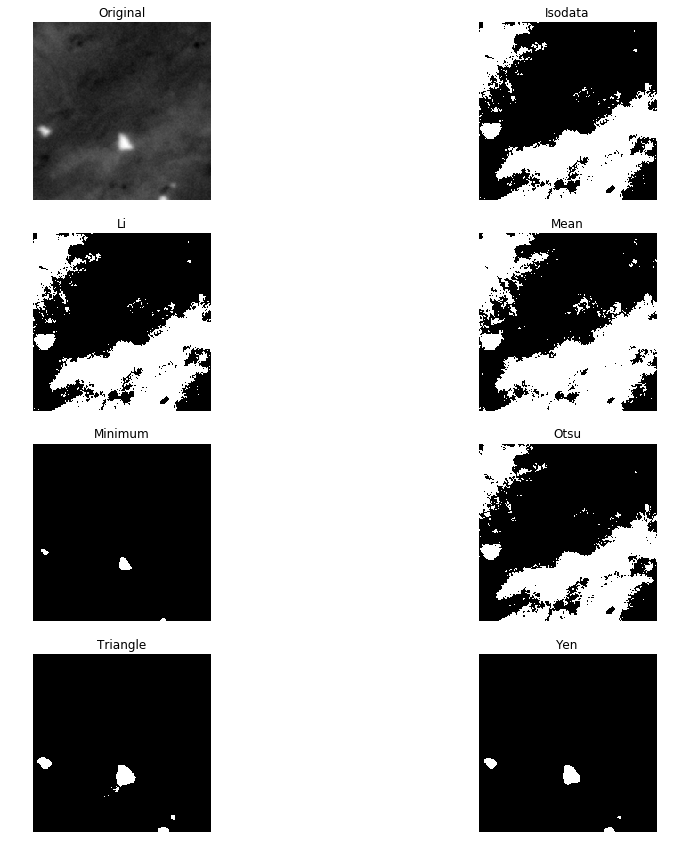

In [11]:
fig, ax = try_all_threshold(array6d[0,0,0,0,:,:], figsize=(16, 12), verbose=False)
plt.show()

In [12]:
# 2D Function
def autoThresholding(image2d,
                     method='global_otsu',
                     radius = 10):
    # calculate global Otsu threshold
    if method=='global_otsu':
        thresh = threshold_otsu(image2d)
        #binary = image2D > thresh
    
    # claculate local Otsu threshold
    if method=='local_otsu':
        thresh = rank.otsu(image2D, disk(radius))
    
    # apply calculated theshold to the input image
    binary = image2d > thresh
    
    return binary

def highpass(image2d,
             sig=300):
    
    lowpass = gaussian(image2d, sigma=sig, mode='nearest')
    highpass = image2d - lowpass
    
    return highpass

In [13]:
# Apply 2D function to 6D array
dimS = img6d.shape[0]
dimT = img6d.shape[1]
dimZ = img6d.shape[2]
dimC = img6d.shape[3]
#dimX = img6d.shape[4]
#dimY = img6d.shape[5]
dimX = x2-x1
dimY = y2-y1

In [14]:
#binary6D = np.zeros(MetaInfo['Sizes'])
out6d = np.zeros([dimS, dimT, dimZ, dimC, dimX, dimY])
nS, nT, nZ, nC, nX, nY = np.shape(out6d)

print(nS, nT, nZ, nC, nX, nY)

1 1 1 1 200 200


In [15]:
for s, t, z, c in it.product(range(nS), range(nT), range(nZ), range(nC)):

    # get 2D image
    tmp = array6d[s,t,z,c,:,:]
    #tmp = highpass(tmp, sig=300)
    #tmp = rank.median(tmp, square(5))
    tmp, background = subtract_background_rolling_ball(tmp, 10,
                                                       light_background=False,
                                                       use_paraboloid=False,
                                                       do_presmooth=False)

    out6d[s,t,z,c,:,:] = autoThresholding(tmp, method='global_otsu', radius=200)
    #out6d[s,t,z,c,:,:] = tmp

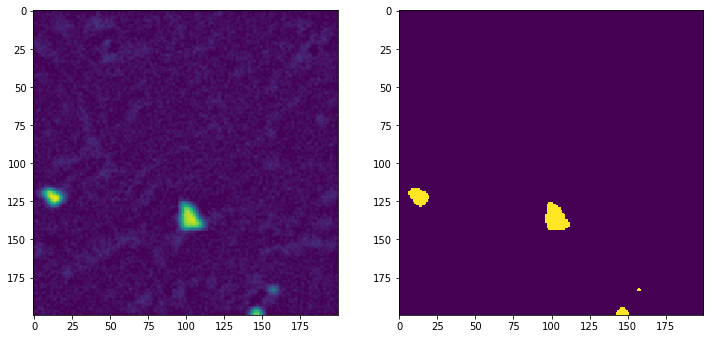

In [16]:
#fig, axes = plt.subplots(2, 3)
fig, ax = plt.subplots(1,2, figsize=(12, 12))


ax[0].imshow(array6d[0,0,0,0,:,:])
ax[1].imshow(out6d[0,0,0,0,:,:])
plt.show()

In [20]:
outputname = 'particleimage.ome.tiff'
tifffile.imsave(outputname, out6d, description=omexml, metadata={'axes': 'STZCXY'})

In [ ]:
# Write Omexml to file with pretty format
# pip install elementpath
omexmlString = prettify(omexml.decode("utf-8"))

text_file = open("ome.xml", "w")
text_file.write(omexmlString)
text_file.close()